# Import Important libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import randrange, uniform
from time import time
import glob
import shutil
import itertools
from time import time
from tensorflow.keras.applications.vgg16 import preprocess_input 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# Image size
IMG_SIZE = 224

# Dataset folder
DATADIR = "dataset"

# Five classes/folders
CATEGORIES = ["aljadd", "nossaiba", "nouhaila", "langze", "unknown"]

# Preprocessing

In [2]:
!pwd

/cygdrive/c/Users/install.PO-ETU007/Desktop/MyProjects/iEars/Model training/Face identification


In [3]:
train_path = "dataset/train"
valid_path = "dataset/valid"
test_path = "dataset/test"

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=train_path, target_size=(224, 224), classes=["aljadd", "nossaiba", "nouhaila", "langze", "unknown"], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=valid_path, target_size=(224, 224), classes=["aljadd", "nossaiba", "nouhaila", "langze", "unknown"], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224, 224), classes=["aljadd", "nossaiba", "nouhaila", "langze", "unknown"], batch_size=10, shuffle=False)

Found 3250 images belonging to 5 classes.
Found 350 images belonging to 5 classes.
Found 851 images belonging to 5 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


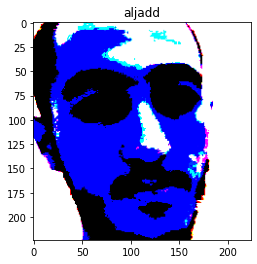

In [53]:
# Let's plot a preprocessed sample
imgs, labels = next(train_batches)
sample = random.randint(0, 9)
plt.imshow(imgs[sample])
plt.title(CATEGORIES[np.argmax(labels[sample])])
plt.show()

### Build VGG16 model

In [25]:
# Load a pretrained VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [26]:
# Add all VGG16 layers to a sequential model except last layer as we will train the model on only 5 classes
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [28]:
# Don't train pretrained layers
for layer in model.layers:
    layer.trainable = False

In [29]:
# Add our last layer, units is the number of our classes
model.add(Dense(units=5, activation='softmax'))

In [30]:
# Compiling our model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model

In [31]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=4)

Epoch 1/4
325/325 [==============================] - 694s 2s/step - loss: 0.0536 - accuracy: 0.9511 - val_loss: 0.0241 - val_accuracy: 0.9886
Epoch 2/4
325/325 [==============================] - 678s 2s/step - loss: 0.0090 - accuracy: 0.9938 - val_loss: 0.0203 - val_accuracy: 0.9886
Epoch 3/4
325/325 [==============================] - 679s 2s/step - loss: 0.0044 - accuracy: 0.9963 - val_loss: 0.0294 - val_accuracy: 0.9857
Epoch 4/4
325/325 [==============================] - 678s 2s/step - loss: 0.0018 - accuracy: 0.9991 - val_loss: 0.0199 - val_accuracy: 0.9857


### Evaluate the model on the test set

In [32]:
# Prediction on test set
predictions = model.predict(x=test_batches, verbose=2)

# Get binary output
y_pred = np.argmax(predictions, axis=1)

# Accuracy
accuracy = np.sum(test_batches.classes==y_pred)/len(y_pred)
print(f'Accuracy of our model is: {accuracy}')

86/86 - 159s
Accuracy of our model is: 0.9882491186839013


# Save model

In [ ]:
model.save("model_h5_format/vgg16_5classes.h5")

# Load model

In [50]:
model = load_model("model_h5_format/vgg16_5classes.h5")

### Run inference on choosed image

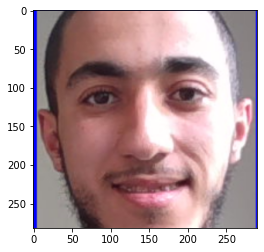

In [4]:
# Load an image from our choice
testing_path = "testing/"
image = cv2.imread('testing/me/me.png', cv2.COLOR_BGR2RGB)[:,:,::-1]
plt.imshow(image)
plt.show()

In [5]:
image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
pre_image = preprocess_input(image_resized)
image_expanded = np.expand_dims(pre_image, axis=0)
prediction = model.predict(image_expanded)
index = np.argmax(model.predict(image_expanded))
classe = CATEGORIES[index]
classe

'aljadd'

## Real time test

In [6]:
# Make prediction from image (jpg format ...):
def predict_from_frame(image, model, IMG_SIZE=224):
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    pre_image = preprocess_input(image_resized)
    image_expanded = np.expand_dims(pre_image, axis=0)
    prediction = model.predict(image_expanded)
    index = np.argmax(model.predict(image_expanded))
    classe = CATEGORIES[index]   
    return classe

In [7]:
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
last_time = time()
face_cascade = cv2.CascadeClassifier("cascades/data/haarcascade_frontalface_default.xml")


while True:
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(rgb, scaleFactor=1.05, minNeighbors=5)
    for (x, y, w, h) in faces:
        roi = rgb[y:y+h, x:x+w]
    
        
        
        color = (255, 0, 0) 
        stroke = 2
        end_cord_x = x + w
        end_cord_y = y + h 
        cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)
        p = predict_from_frame(image=roi, model=model) 
        cv2.putText(frame, p , (x,y), font, 1, (0, 0, 255), 1,1)


          
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

# Create dataset

In [69]:
person = 'aljadd'

In [5]:
cap = cv2.VideoCapture(0)
#font = cv2.FONT_HERSHEY_SIMPLEX
#last_time = time()
#face_cascade = cv2.CascadeClassifier("cascades/data/haarcascade_frontalface_default.xml")
i = 999

while True:
    ret, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    '''
    #faces = face_cascade.detectMultiScale(rgb, scaleFactor=1.05, minNeighbors=5)
    for (x, y, w, h) in faces:
        roi = rgb[y:y+h, x:x+w]
    
        
        
        color = (255, 0, 0) 
        stroke = 2
        end_cord_x = x + w
        end_cord_y = y + h 
        cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)
        if time() > last_time + 0.25:     
            cv2.imwrite(f"datanew/{person}/z_{person}{i}.jpg", cv2.cvtColor(roi, cv2.COLOR_RGB2BGR))
            i += 1
            last_time = time()
    
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    '''
    
        
    if 1 > 0:     
        cv2.imwrite(f"test.jpg", cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        break
    
cap.release()
cv2.destroyAllWindows()